In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

# HRNet

## Libs setup and imports

Installs required libs and creates util functions

In [ ]:
%pip install lapixdl==0.7.19 # For model evaluation
%pip install -U albumentations # For data augmentations
%pip install torch==1.7.1 torchvision==0.8.2 # For HRNet compatibility

In [ ]:
# Installs HRNet from the git source

!git clone https://github.com/HRNet/HRNet-Image-Classification /HRNet

with open("/HRNet/requirements.txt") as file:
    filedata = file.read()
filedata = filedata.replace(
    "opencv-python==3.4.1.15", "opencv-python==3.4.2.17"
)  # Fix OpenCV version
with open("/HRNet/requirements.txt", "w") as file:
    file.write(filedata)

%pip install -r /HRNet/requirements.txt

import sys

sys.path.append("/HRNet/lib")

In [ ]:
import fnmatch
import logging
import os
import random
import shutil
import time
import timeit
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import models

# HRNet
import models.cls_hrnet as cls_hrnet
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from config import config as cfg
from config.models import POSE_HIGH_RESOLUTION_NET as MODEL_CONFIGS
from core.function import AverageMeter
from lapixdl.evaluation.model import Classification
from lapixdl.evaluation.visualize import show_classifications
from matplotlib.colors import ListedColormap
from PIL import Image
from scipy.io import savemat
from tensorboardX import SummaryWriter
from torch.nn import functional as F
from utils.utils import create_logger, get_optimizer, save_checkpoint

# Fix seeds
random.seed(1462)
torch.manual_seed(1462)

# HRNet needs distributed config
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "1234"
dist.init_process_group("nccl", rank=0, world_size=1, init_method="env://")

## Utils

In [ ]:
# Remaps classes if needed
def simplify_normal(cls_idx):
    return 3 if cls_idx in [2, 6] else cls_idx


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## Paths and metadata configuration

Fill the paths accordingly to the structure of the dataset and the output directories.

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

In [ ]:
path_img = Path('[images root folder]']) # Images root folder. The images must be inside the [train|val|test]/[class] folders.
path_output = Path('[output root folder]')
path_models = path_output/'Models/Outputs/classification/models_hrnet_18_v41'

## Train pipeline setup



## Architecture Definition

The complete list of supported models is available at https://github.com/HRNet/HRNet-Image-Classification#imagenet-pretrained-models

In [ ]:
# You need to find the correct configuration inside the /HRNet/experiments/ folder
model_cfg_file = "/HRNet/experiments/cls_hrnet_w18_sgd_lr5e-2_wd1e-4_bs32_x100.yaml"

In [ ]:
# Downloads the pretrained model to /pretrained.pth. The weights must be compatible with the chosen configuration.
#!wget "https://opr0mq.dm.files.1drv.com/y4mIoWpP2n-LUohHHANpC0jrOixm1FZgO2OsUtP2DwIozH5RsoYVyv_De5wDgR6XuQmirMV3C0AljLeB-zQXevfLlnQpcNeJlT9Q8LwNYDwh3TsECkMTWXCUn3vDGJWpCxQcQWKONr5VQWO1hLEKPeJbbSZ6tgbWwJHgHF7592HY7ilmGe39o5BhHz7P9QqMYLBts6V7QGoaKrr0PL3wvvR4w" -O "/pretrained.pth"

### Pipeline

In [ ]:
# Augmentations setup


def albumentation_transforms(img):
    return A.Compose(
        [
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Rotate((-10, 10), p=0.75),
            A.RandomBrightnessContrast(0.1, 0.1, p=0.75),
            A.Affine(p=0.75, shear=0.2),
        ]
    )(image=np.array(img))["image"]


augmentations = transforms.Compose(
    [
        albumentation_transforms,
        transforms.ToTensor(),
        normalize,
    ]
)

In [ ]:
bs = 64  # Adjust the batch size accordingly to the GPU VRAM capacity

# Normalization statistics
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# train_dataset.classes:
# ['abnormal',
# 'blood',
# 'dividing',
# 'normal',
# 'not_defined',
# 'out_of_focus',
# 'reactive']

train_dir = path_img / "train"
train_dataset = datasets.ImageFolder(
    train_dir,
    augmentations,
    normalize
    # target_transform=simplify_normal
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs, shuffle=True, num_workers=1, pin_memory=True
)

val_dir = path_img / "val"
val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([transforms.ToTensor(), normalize]),
    # target_transform=simplify_normal
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=bs, shuffle=False, num_workers=1, pin_memory=True
)

In [ ]:
# Training configuration

cudnn.benchmark = True
cudnn.deterministic = False
cudnn.enabled = True

cfg.defrost()
cfg.merge_from_file(model_cfg_file)

cfg.OUTPUT_DIR = str(path_models)
cfg.LOG_DIR = str(path_models)
cfg.GPUS = (0,)
cfg.WORKERS = 4
cfg.PRINT_FREQ = 20
cfg.AUTO_RESUME = False
cfg.PIN_MEMORY = True
cfg.RANK = 0

cfg.DATASET.DATASET = "ufsc-ocpap"
cfg.DATASET.DATA_FORMAT = "png"
cfg.DATASET.ROOT = str(path_img)
cfg.DATASET.TEST_SET = "val"
cfg.DATASET.TRAIN_SET = "train"

cfg.MODEL.PRETRAINED = ""  #'/pretrained.pth' # Loads pretrained weights
cfg.MODEL.IMAGE_SIZE = [256, 256]

# Training

cfg.TRAIN.LR_FACTOR = 0.1
cfg.TRAIN.LR_STEP = [30, 60, 90]
cfg.TRAIN.LR = 0.05

cfg.TRAIN.OPTIMIZER = "adam"
cfg.TRAIN.MOMENTUM = 0.9
cfg.TRAIN.WD = 0.0001
cfg.TRAIN.NESTEROV = True

cfg.TRAIN.BEGIN_EPOCH = 0
cfg.TRAIN.END_EPOCH = 100

cfg.TRAIN.RESUME = True

cfg.TRAIN.SHUFFLE = True

# Validation

cfg.TEST.MODEL_FILE = ""
cfg.TEST.FLIP_TEST = False
cfg.TEST.SHIFT_HEATMAP = False
cfg.TEST.USE_GT_BBOX = False

cfg.freeze()

In [ ]:
# Output and Logs

final_output_dir = path_models

root_output_dir = Path(cfg.OUTPUT_DIR)
if not root_output_dir.exists():
    print(f"=> creating {root_output_dir}")
    root_output_dir.mkdir()

dataset = cfg.DATASET.DATASET
model_name = "hrnet_18"

print(f"=> creating {final_output_dir}")
final_output_dir.mkdir(parents=True, exist_ok=True)

time_str = time.strftime("%Y-%m-%d-%H-%M")
log_file = "{}_{}.log".format(time_str, "train")
final_log_file = final_output_dir / log_file
head = "%(asctime)-15s %(message)s"
logging.basicConfig(filename=str(final_log_file), format=head)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
console = logging.StreamHandler()
logging.getLogger("").addHandler(console)

tensorboard_log_dir = Path(cfg.LOG_DIR) / dataset / model_name / (time_str)
print(f"=> creating {tensorboard_log_dir}")
tensorboard_log_dir.mkdir(parents=True, exist_ok=True)

writer_dict = {
    "writer": SummaryWriter(log_dir=tensorboard_log_dir),
    "train_global_steps": 0,
    "valid_global_steps": 0,
}

## Training

In [ ]:
model = eval("models." + cfg.MODEL.NAME + ".get_cls_net")(cfg)

gpus = list(cfg.GPUS)
model = torch.nn.DataParallel(model, device_ids=gpus).cuda()
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = get_optimizer(cfg, model)

In [ ]:
best_perf = 0.0
best_model = False
last_epoch = cfg.TRAIN.BEGIN_EPOCH
if cfg.TRAIN.RESUME:
    model_state_file = os.path.join(final_output_dir, "checkpoint.pth.tar")
    if os.path.isfile(model_state_file):
        checkpoint = torch.load(model_state_file)
        last_epoch = checkpoint["epoch"]
        best_perf = checkpoint["perf"]
        model.module.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        logger.info("=> loaded checkpoint (epoch {})".format(checkpoint["epoch"]))
        best_model = True

if isinstance(cfg.TRAIN.LR_STEP, list):
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, cfg.TRAIN.LR_STEP, cfg.TRAIN.LR_FACTOR, last_epoch - 1
    )
else:
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, cfg.TRAIN.LR_STEP, cfg.TRAIN.LR_FACTOR, last_epoch - 1
    )

In [ ]:
# Shows tensorboard
%reload_ext tensorboard
%tensorboard --logdir {tensorboard_log_dir}

In [ ]:
# Debug
# CUDA_LAUNCH_BLOCKING="1"

In [ ]:
# Define training and validation functions


def train(
    config,
    train_loader,
    model,
    criterion,
    optimizer,
    epoch,
    output_dir,
    tb_log_dir,
    writer_dict,
):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        # target = target - 1 # Specific for imagenet

        # compute output
        output = model(input)
        target = target.cuda(non_blocking=True)

        loss = criterion(output, target)

        # compute gradient and do update step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        prec1, prec5 = accuracy(output, target, (1, 5))

        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % config.PRINT_FREQ == 0:
            msg = (
                "Epoch: [{0}][{1}/{2}]\t"
                "Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t"
                "Speed {speed:.1f} samples/s\t"
                "Data {data_time.val:.3f}s ({data_time.avg:.3f}s)\t"
                "Loss {loss.val:.5f} ({loss.avg:.5f})\t"
                "Accuracy@1 {top1.val:.3f} ({top1.avg:.3f})\t"
                "Accuracy@5 {top5.val:.3f} ({top5.avg:.3f})\t".format(
                    epoch,
                    i,
                    len(train_loader),
                    batch_time=batch_time,
                    speed=input.size(0) / batch_time.val,
                    data_time=data_time,
                    loss=losses,
                    top1=top1,
                    top5=top5,
                )
            )
            logger.info(msg)

            if writer_dict:
                writer = writer_dict["writer"]
                global_steps = writer_dict["train_global_steps"]
                writer.add_scalar("train_loss", losses.val, global_steps)
                writer.add_scalar("train_top1", top1.val, global_steps)
                writer_dict["train_global_steps"] = global_steps + 1


def validate(
    config, val_loader, model, criterion, output_dir, tb_log_dir, writer_dict=None
):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            # compute output
            output = model(input)

            target = target.cuda(non_blocking=True)

            loss = criterion(output, target)

            # measure accuracy and record loss
            losses.update(loss.item(), input.size(0))
            prec1, prec5 = accuracy(output, target, (1, 5))
            top1.update(prec1[0], input.size(0))
            top5.update(prec5[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

        msg = (
            "Test: Time {batch_time.avg:.3f}\t"
            "Loss {loss.avg:.4f}\t"
            "Error@1 {error1:.3f}\t"
            "Error@5 {error5:.3f}\t"
            "Accuracy@1 {top1.avg:.3f}\t"
            "Accuracy@5 {top5.avg:.3f}\t".format(
                batch_time=batch_time,
                loss=losses,
                top1=top1,
                top5=top5,
                error1=100 - top1.avg,
                error5=100 - top5.avg,
            )
        )
        logger.info(msg)

        if writer_dict:
            writer = writer_dict["writer"]
            global_steps = writer_dict["valid_global_steps"]
            writer.add_scalar("valid_loss", losses.avg, global_steps)
            writer.add_scalar("valid_top1", top1.avg, global_steps)
            writer_dict["valid_global_steps"] = global_steps + 1

    return top1.avg

In [ ]:
# Train

logger = logging.getLogger(__name__)
for epoch in range(last_epoch, cfg.TRAIN.END_EPOCH):
    # train for one epoch
    train(
        cfg,
        train_loader,
        model,
        criterion,
        optimizer,
        epoch,
        final_output_dir,
        tensorboard_log_dir,
        writer_dict,
    )
    lr_scheduler.step()
    # evaluate on validation set
    perf_indicator = validate(
        cfg,
        val_loader,
        model,
        criterion,
        final_output_dir,
        tensorboard_log_dir,
        writer_dict,
    )

    if perf_indicator > best_perf:
        best_perf = perf_indicator
        best_model = True
    else:
        best_model = False

    logger.info(f"=> saving checkpoint to {final_output_dir}")
    save_checkpoint(
        {
            "epoch": epoch + 1,
            "model": cfg.MODEL.NAME,
            "state_dict": model.module.state_dict(),
            "perf": perf_indicator,
            "optimizer": optimizer.state_dict(),
        },
        best_model,
        final_output_dir,
        filename="checkpoint.pth.tar",
    )

final_model_state_file = os.path.join(final_output_dir, "final_state.pth.tar")
logger.info("saving final model state to {}".format(final_model_state_file))
torch.save(model.module.state_dict(), final_model_state_file)
writer_dict["writer"].close()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch: [1][0/365]	Time 38.265s (38.265s)	Speed 1.7 samples/s	Data 35.436s (35.436s)	Loss 1.27922 (1.27922)	Accuracy@1 37.500 (37.500)	Accuracy@5 100.000 (100.000)	
Epoch: [1][20/365]	Time 33.299s (33.758s)	Speed 1.9 samples/s	Data 32.510s (32.869s)	Loss 1.04818 (1.12176)	Accuracy@1 59.375 (46.652)	Accuracy@5 100.000 (100.000)	
Epoch: [1][40/365]	Time 31.916s (34.308s)	Speed 2.0 samples/s	Data 31.124s (33.469s)	Loss 1.23115 (1.11084)	Accuracy@1 3

## Test

Run the metrics evaluations on the test set

In [ ]:
from lapixdl.evaluation.evaluate import evaluate_classification
from tqdm import tqdm

In [ ]:
test_dir = path_img / "test"
test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([transforms.ToTensor(), normalize]),
    is_valid_file=lambda path: not "/bbox_" in path,
    target_transform=simplify_normal,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True
)

In [ ]:
gt_classes = []
pred_classes = []

model.eval()
with torch.no_grad():
    for _, (input, target) in enumerate(tqdm(test_loader)):
        output = model(input)
        _, pred = output.topk(1, 1, True, True)
        pred = pred.t()
        pred

        gt_classes.append(Classification(int(target)))
        pred_classes.append(Classification(int(pred[0])))

5042 samples [00:00, 512633.77 samples/s]
/usr/local/lib/python3.7/dist-packages/lapixdl/evaluation/model.py:217: RuntimeWarning: invalid value encountered in long_scalars
  return self.TP/(self.FP + self.TP)


Classification Metrics:
	Sample Count: 5042
	Accuracy: 0.6856406188020627
	Avg Recall: 0.5600167873714061
	Avg Precision: 0.681335774511752
	Avg Specificity: 0.9354023421732413
	Avg FPR: 0.06459765782675884
	Avg F-Score: 0.6834097666059157

By Class:

abnormal:
	TP: 1122
	TN: 2781
	FP: 591
	FN: 548
	FPR: 0.17526690391459074
	Accuracy: 0.7740975803252678
	Recall: 0.6718562874251497
	Precision: 0.6549912434325744
	Specificity: 0.8247330960854092
	F-Score: 0.6633165829145728
blood:
	TP: 420
	TN: 4118
	FP: 255
	FN: 249
	FPR: 0.05831237136976904
	Accuracy: 0.9000396667988894
	Recall: 0.6278026905829597
	Precision: 0.6222222222222222
	Specificity: 0.9416876286302309
	F-Score: 0.625
dividing:
	TP: 0
	TN: 5042
	FP: 0
	FN: 0
	FPR: 0.0
	Accuracy: 1.0
	Recall: No positive cases in GT
	Precision: 1
	Specificity: 1.0
	F-Score: 1
normal:
	TP: 742
	TN: 4019
	FP: 160
	FN: 121
	FPR: 0.0382866714525006
	Accuracy: 0.9442681475604918
	Recall: 0.8597914252607184
	Precision: 0.8226164079822617
	Specificity:

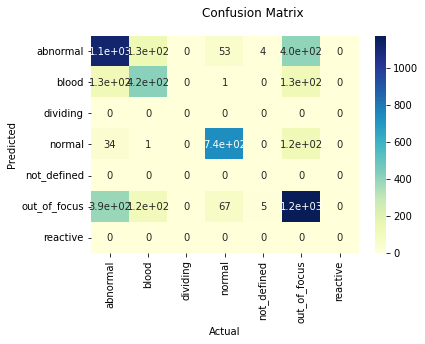

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfc0b23890>)

In [ ]:
eval = evaluate_classification(gt_classes, pred_classes, test_dataset.classes)
eval.show_confusion_matrix()

## Visual Demo

Pretty print a model prediction

In [ ]:
import fastai.vision as fv
import PIL
from lapixdl.evaluation.model import Result
from lapixdl.evaluation.visualize import show_classifications

In [ ]:
test_image_files = fv.get_image_files(path_img / "test", recurse=True)

In [ ]:
cudnn.benchmark = True
cudnn.deterministic = False
cudnn.enabled = True

cfg.defrost()
cfg.merge_from_file(model_cfg_file)

cfg.GPUS = (0,)
cfg.WORKERS = 4
cfg.PRINT_FREQ = 20
cfg.AUTO_RESUME = False
cfg.PIN_MEMORY = True
cfg.RANK = 0

cfg.DATASET.DATASET = "ufsc-ocpap"
cfg.DATASET.DATA_FORMAT = "png"
cfg.DATASET.ROOT = str(path_img)
cfg.DATASET.TEST_SET = "val"
cfg.DATASET.TRAIN_SET = "train"

cfg.MODEL.PRETRAINED = ""  #'/pretrained.pth'
cfg.MODEL.IMAGE_SIZE = [256, 256]

# Validation

cfg.TEST.MODEL_FILE = ""
cfg.TEST.FLIP_TEST = False
cfg.TEST.SHIFT_HEATMAP = False
cfg.TEST.USE_GT_BBOX = False

cfg.freeze()

ic_model = eval("models." + cfg.MODEL.NAME + ".get_cls_net")(cfg)

model_state_file = os.path.join(path_models, "final_state.pth.tar")
ic_model.load_state_dict(torch.load(model_state_file))

gpus = list(cfg.GPUS)
ic_model = nn.DataParallel(ic_model, device_ids=gpus).cuda()

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

tms = transforms.Compose(
    [
        transforms.ToTensor(),
        normalize,
    ]
)

ic_trans_model = lambda img: ic_model(tms(img)[None, ...])

=> init weights from normal distribution


In [ ]:
test_dataset.classes

['abnormal',
 'blood',
 'dividing',
 'normal',
 'not_defined',
 'out_of_focus',
 'reactive']

In [ ]:
vis_codes = [
    "Abnormal",
    "Blood",
    "Dividing",
    "Healthy",
    "Not Defined",
    "Out of Focus",
    "Reactive",
]

img_stem = "2019_07_10__14_48__0045_b0s0c0x181669-1600y20740-1200m2957"

test_img_nuclei_paths = [
    p
    for p in test_image_files
    if not p.stem.startswith("bbox_") and p.stem.endswith(img_stem)
]

results = []
for nuclei_path in test_img_nuclei_paths:
    gt_cls_name = nuclei_path.parent.stem
    gt_cls = test_dataset.classes.index(gt_cls_name)
    nuclei_pil_img = PIL.Image.open(nuclei_path).convert("RGB")
    output = ic_trans_model(nuclei_pil_img)
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, clas = torch.max(probs, 1)

    results.append(
        Result(
            np.array(nuclei_pil_img),
            Classification(gt_cls),
            Classification(clas, round(float(conf), 2)),
        )
    )

fig, axes = show_classifications(results, vis_codes, cols=7)

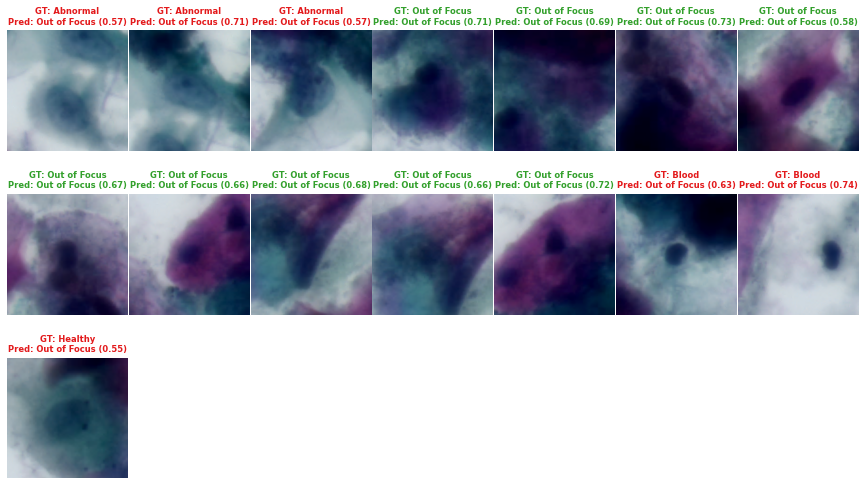

In [ ]:
for line in axes:
    for axe in line:
        axe.title.set_fontweight("bold")

fig.suptitle("")
fig.set_figheight(7)
fig.set_figwidth(12)
fig